In [36]:
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
# from causalml.dataset import synthetic_data
import numpy as np
from dataloader import load_IHDP_data
from visualizations import plot_cates_uber, plot_cates
from causalml.metrics import *
from matplotlib import pyplot as plt 
import seaborn as sns

data = load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

#concatenate t so we can use it as input
xt = np.concatenate([data['x'], data['t']], 1)

X = data['x']
z = data['t'].reshape(-1)
y = data['y'].reshape(-1)

ite = data['mu_1'] - data['mu_0']


In [2]:
def get_metrics(name, model):
    pred = model.fit_predict(X, z, y).reshape(-1)
    try:
        ate, lb, ub = model.estimate_ate(X, z, y, return_ci=True) #95% CI
    except:
        ate, lb, ub = model.estimate_ate(X, z, y)
    mad_metric = abs(ate - np.mean(ite))
    pehe = rmse(pred, ite)
    return (pred, [name, pehe, mad_metric[0], lb[0], ub[0]])

#### S-Learner OLS

Using a classical linear regression model to estimate ATE is standard, but using it to estimate CATE is problematic. While the ATE may be accurate when estimating using linear regression, the CATE under linear regression is equal to the ATE for all units. Intuitively, we should expect units with a particular set of features to have a different CATE compared to units with a different set of features. In reality, it is naive to assume a treatment treats all units in the exact same manner and here in lies the inspiration for more powerful machine learning techniques to acurately estimate the heterogenous effect of individual units. 

In [33]:
import pandas as pd
ols = BaseSLearner(learner=LinearRegression())


cate_ols_outcome, slearner_ols_results = get_metrics("S Learner (LR)", ols)

In [53]:
slearner_ols_results

['S Learner (LR)',
 1.5418028634501457,
 0.09343173886379663,
 3.669330693081139,
 4.224839646523896]

#### S-Learner MLP

The next approach follows from modern day deep learning techniques and uses a multilayer perceptron as the basis for our S-Learner. 

In [104]:
s_mlp = BaseSLearner(learner=MLPRegressor(hidden_layer_sizes = [100,100], batch_size=64, max_iter=1000))
cate_s_mlp_outcome, slearner_mlp_results = get_metrics("S Learner (MLP)", s_mlp)
slearner_mlp_results

['S Learner (MLP)',
 1.1477981520272873,
 0.086326683365193,
 3.8219141620996373,
 4.05804606650819]

##### Hyperparameter Tuning

In [21]:
# lrs= [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
# num_hidden_layers = [1,3,5]
# hidden_layer_sizes = [20,50,100,200]
# data = []
# for lr in lrs:
#     for layer in num_hidden_layers:
#         for sizes in hidden_layer_sizes:
#             layer_dims = [sizes for i in np.arange(layer)]
#             s_mlp = BaseSLearner(learner=MLPRegressor(hidden_layer_sizes=layer_dims, batch_size=64, max_iter=1000, learning_rate_init=lr))
#             cate_s_mlp_outcome, slearner_mlp_results = get_metrics("S Learner (MLP)", s_mlp)
#             print(lr, layer, sizes)
#             data.append(slearner_mlp_results + [lr, layer, sizes])


In [8]:
import pandas as pd

hyper_results_s_mlp = pd.DataFrame(data=data, 
columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB", "lr", "layers", "hidden_dim"])
hyper_results_s_mlp.sort_values(by='PEHE').head(5)

,Learner,PEHE,Mean Abs Diff (ATE),LB,UB,lr,layers,hidden_dim
8,S Learner (MLP),0.792384,0.089417,3.727530,4.158611,0.1000,5,20
4,S Learner (MLP),0.805291,0.102012,3.563692,3.939591,0.1000,3,20
39,S Learner (MLP),0.816305,0.066373,3.626475,3.948086,0.0001,1,200
44,S Learner (MLP),0.823229,0.154366,3.506773,3.891801,0.0001,5,20
0,S Learner (MLP),0.838316,0.057877,3.719066,4.103994,0.1000,1,20


In [9]:
hyper_results_s_mlp.sort_values(by='Mean Abs Diff (ATE)').head(5)

,Learner,PEHE,Mean Abs Diff (ATE),LB,UB,lr,layers,hidden_dim
34,S Learner (MLP),1.239982,0.001738,3.737038,3.966792,0.001,5,100
27,S Learner (MLP),1.005671,0.002533,3.739052,3.963188,0.001,1,200
24,S Learner (MLP),0.887292,0.003152,3.681905,4.019097,0.001,1,20
35,S Learner (MLP),1.046403,0.003651,3.739212,3.960794,0.001,5,200
13,S Learner (MLP),0.883394,0.004702,3.712871,3.985033,0.010,1,50


#### T-Learner MLP

In [31]:
# lr=0.1000,layer=7, neurons=20
layer = [20 for i in np.arange(10)]
t_mlp = BaseTLearner(learner=MLPRegressor(hidden_layer_sizes=layer, learning_rate_init=1e-5, batch_size=64, max_iter=3000))

cate_t_mlp_outcome, tlearner_mlp_results = get_metrics("T Learner (MLP)", t_mlp)
tlearner_mlp_results

# ate, lb, ub = t_mlp.estimate_ate(X, z, y)
# print("Average Treatment Effect (True = %2f): %2f" % (np.average(data['mu_1']-data['mu_0']), ate))
# print("Confidence Interval (CI): %2f, %2f " % (lb, ub))

['T Learner (MLP)',
 1.0575366876522916,
 0.25098444914402895,
 3.3472293132221895,
 3.858108650367194]

In [19]:
# lrs= [1e-1, 1e-2, 1e-3, 1e-4]
# num_hidden_layers = [1,3,5,7]
# hidden_layer_sizes = [20,50,100]

# t_hyper_data = []
# for lr in lrs:
#     for layer in num_hidden_layers:
#         for sizes in hidden_layer_sizes:
#             layer_dims = [sizes for i in np.arange(layer)]
#             t_mlp = BaseTLearner(learner=MLPRegressor(hidden_layer_sizes=layer_dims, batch_size=64, max_iter=1000, learning_rate_init=lr))
#             cate_t_mlp_outcome, tlearner_mlp_results = get_metrics("T Learner (MLP)", t_mlp)
#             print(lr, layer, sizes)
#             t_hyper_data.append(tlearner_mlp_results + [lr, layer, sizes])

In [11]:
hyper_results_t_mlp = pd.DataFrame(data=t_hyper_data, 
columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB", "lr", "layers", "hidden_dim"])
hyper_results_t_mlp.sort_values(by='PEHE').head(5)

,Learner,PEHE,Mean Abs Diff (ATE),LB,UB,lr,layers,hidden_dim
9,T Learner (MLP),0.735074,1.112536,4.729693,5.202686,0.1000,7,20
42,T Learner (MLP),0.968608,0.251504,3.384521,3.819779,0.0001,5,20
6,T Learner (MLP),0.991964,0.217325,3.383124,3.889532,0.1000,5,20
45,T Learner (MLP),1.012531,0.278117,3.368818,3.782256,0.0001,7,20
39,T Learner (MLP),1.063586,0.322392,3.300470,3.762053,0.0001,3,20


In [12]:
hyper_results_t_mlp.sort_values(by='Mean Abs Diff (ATE)').head(5)

,Learner,PEHE,Mean Abs Diff (ATE),LB,UB,lr,layers,hidden_dim
34,S Learner (MLP),1.239982,0.001738,3.737038,3.966792,0.001,5,100
27,S Learner (MLP),1.005671,0.002533,3.739052,3.963188,0.001,1,200
24,S Learner (MLP),0.887292,0.003152,3.681905,4.019097,0.001,1,20
35,S Learner (MLP),1.046403,0.003651,3.739212,3.960794,0.001,5,200
13,S Learner (MLP),0.883394,0.004702,3.712871,3.985033,0.010,1,50


#### X-Learner

After running through a grid search for hyper parameter tuning, using a learning rate of 1e-4, 5 layers, and 20 neurons per layer was optimal in minimizing PEHE, our most valued statistic for CATE. Even though this particular combination did not have the best estimate for ATE, our focus on CATE is what makes this particular model most meaningful.

In [64]:
%%capture 
x_mlp = BaseXLearner(learner=MLPRegressor(hidden_layer_sizes=(100), batch_size=64, max_iter=2000,activation="relu"))
cate_x_mlp_outcome, xlearner_mlp_results = get_metrics("X Learner (MLP)", x_mlp)

In [65]:
xlearner_mlp_results

['X Learner (MLP)',
 1.4299253998348878,
 0.02896604771750555,
 3.744880088463736,
 4.020358868848716]

In [20]:
# %%capture 

# x_hyper_data = []
# for lr in lrs:
#     for layer in num_hidden_layers:
#         for sizes in hidden_layer_sizes:
#             layer_dims = [sizes for i in np.arange(layer)]
#             x_mlp = BaseXLearner(learner=MLPRegressor(hidden_layer_sizes=layer_dims, batch_size=64, max_iter=1000, learning_rate_init=lr))
#             cate_x_mlp_outcome, xlearner_mlp_results = get_metrics("X Learner (MLP)", x_mlp)
#             print(lr, layer, sizes)
#             x_hyper_data.append(xlearner_mlp_results + [lr, layer, sizes])

In [15]:
hyper_results_x_mlp = pd.DataFrame(data=x_hyper_data, 
columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB", "lr", "layers", "hidden_dim"])
hyper_results_x_mlp.sort_values(by='PEHE').head(5)

,Learner,PEHE,Mean Abs Diff (ATE),LB,UB,lr,layers,hidden_dim
42,X Learner (MLP),0.888559,0.053024,3.592086,4.009173,0.0001,5,20
39,X Learner (MLP),0.889472,0.208808,3.444413,3.845278,0.0001,3,20
45,X Learner (MLP),0.967751,0.073064,3.738887,4.114547,0.0001,7,20
38,X Learner (MLP),0.974174,0.261183,3.366810,3.818130,0.0001,1,100
36,X Learner (MLP),0.980684,0.329632,3.275566,3.772476,0.0001,1,20


In [16]:
hyper_results_x_mlp.sort_values(by='Mean Abs Diff (ATE)').head(5)

,Learner,PEHE,Mean Abs Diff (ATE),LB,UB,lr,layers,hidden_dim
40,X Learner (MLP),1.130630,0.004604,3.674356,4.023742,0.0001,3,50
12,X Learner (MLP),1.504182,0.012495,3.629881,4.052435,0.0100,1,20
46,X Learner (MLP),1.377789,0.013609,3.689427,3.990662,0.0001,7,50
32,X Learner (MLP),1.240178,0.014244,3.738010,3.997785,0.0010,5,100
29,X Learner (MLP),1.260907,0.021056,3.701732,3.963463,0.0010,3,100


#### Results

In [66]:
results = pd.DataFrame(data=[slearner_ols_results, slearner_mlp_results, tlearner_mlp_results, xlearner_mlp_results], 
columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB"])

,Learner,PEHE,Mean Abs Diff (ATE),LB,UB
0,S Learner (LR),1.541803,0.093432,3.669331,4.224840
1,S Learner (MLP),1.079374,0.056447,3.677098,3.917314
2,T Learner (MLP),1.590745,0.293695,3.396483,3.723433
3,X Learner (MLP),1.429925,0.028966,3.744880,4.020359


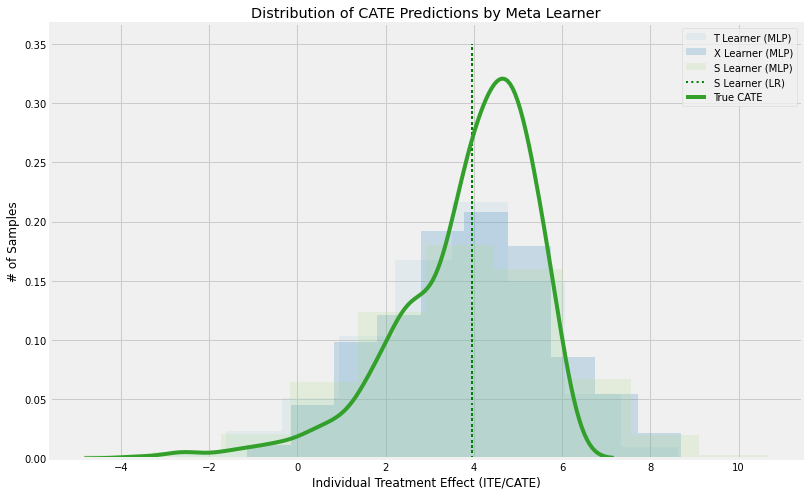

In [46]:
alpha=0.2
plt.figure(figsize=(12,8))
plt.hist(cate_t_mlp_outcome, alpha=alpha, label='T Learner (MLP)', density=True)
plt.hist(cate_x_mlp_outcome,alpha=alpha, label='X Learner (MLP)',  density=True)
plt.hist(cate_s_mlp_outcome,alpha=alpha, label='S Learner (MLP)',  density=True)
plt.vlines(cate_ols_outcome, 0, 0.35, label='S Learner (LR)',
           linestyles='dotted', colors='green', linewidth=2)
sns.kdeplot(ite, label="True CATE")
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()